#Learning Topics in The Daily Kos with the Hierarchical Dirichlet Process

The Hierarchical Dirichlet Process (HDP) is typically used for topic modeling when the number of topics is unknown

Let's explore the topics of the political blog, The Daily Kos using data from the [UCI Machine Learning Repository](http://archive.ics.uci.edu/ml/datasets/Bag+of+Words).

In [2]:
import itertools
import pyLDAvis
import pandas as pd
import re
import simplejson
import seaborn as sns

from microscopes.common.rng import rng
from microscopes.lda.definition import model_definition
from microscopes.lda.model import initialize
from microscopes.lda import model, runner
from random import shuffle

sns.set_style('darkgrid')

%matplotlib inline

First, let's grab the data from UCI:

In [7]:
!curl http://archive.ics.uci.edu/ml/machine-learning-databases/bag-of-words/docword.kos.txt.gz | gunzip > docword.kos.txt
!head docword.kos.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1029k  100 1029k    0     0   494k      0  0:00:02  0:00:02 --:--:--  494k
3430
6906
353160
1 61 2
1 76 1
1 89 1
1 211 1
1 296 1
1 335 1
1 404 1


In [9]:
!curl http://archive.ics.uci.edu/ml/machine-learning-databases/bag-of-words/vocab.kos.txt > vocab.kos.txt
!head vocab.kos.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 55467  100 55467    0     0   103k      0 --:--:-- --:--:-- --:--:--  103k
aarp
abandon
abandoned
abandoning
abb
abc
abcs
abdullah
ability
aboard


```
The format of the docword.os.txt file is 3 header lines, followed by
NNZ triples:
---
D
W
NNZ
docID wordID count
docID wordID count
docID wordID count
docID wordID count
...
docID wordID count
docID wordID count
docID wordID count
---
```

We'll process the data into a list of lists of words ready to be fed into our algorithm:

In [10]:
def parse_bag_of_words_file(docword, vocab):
    with open(vocab, "r") as f:
        kos_vocab = [word.strip() for word in f.readlines()]
        id_to_word = {i: word for i, word in enumerate(kos_vocab)}
        
    with open(docword, "r") as f:
        raw = [map(int, _.strip().split()) for _ in f.readlines()][3:]

    docs = []
    for _, grp in itertools.groupby(raw, lambda x: x[0]):
        doc = []
        for _, word_id, word_cnt in grp:
            doc += word_cnt * [id_to_word[word_id-1]]
        docs.append(doc)
    return docs

In [15]:
docs = parse_bag_of_words_file("docword.kos.txt", "vocab.kos.txt")
vocab_size = len(set(word for doc in docs for word in doc))

We must define our model before we intialize it.  In this case, we need the number of docs and the number of words. 

From there, we can initialize our model and set the hyperparameters

In [18]:
defn = model_definition(len(docs), vocab_size)
prng = rng()
kos_state = initialize(defn, docs, prng, 
                        vocab_hp=1, 
                        dish_hps={"alpha": 1, "gamma": 1})
r = runner.runner(defn, docs, kos_state)

print "number of docs:", defn.n, "vocabulary size:", defn.v

 number of docs: 3430 vocabulary size: 6906


Given the size of the dataset, it'll take some time to run.

We'll run our model for 1000 iterations and save our results every 25 iterations.

In [22]:
%%time
step_size = 50
steps = 500 / step_size

print "randomly initialized model:", "perplexity:", kos_state.perplexity(), "num topics:", kos_state.ntopics()
for s in range(steps):
    r.run(prng, step_size)
    print "iteration:", (s + 1) * step_size, "perplexity:", kos_state.perplexity(), "num topics:", kos_state.ntopics()

randomly initialized model: perplexity: 6908.4715103 num topics: 9
iteration: 50 perplexity: 1598.31129028 num topics: 13
iteration: 100 perplexity: 1584.88109249 num topics: 14
iteration: 150 perplexity: 1578.18024984 num topics: 15
iteration: 200 perplexity: 1572.6513124 num topics: 17
iteration: 250 perplexity: 1572.84546091 num topics: 14
iteration: 300 perplexity: 1572.48998006 num topics: 14
iteration: 350 perplexity: 1571.57216388 num topics: 13
iteration: 400 perplexity: 1571.79611428 num topics: 15
iteration: 450 perplexity: 1572.38387573 num topics: 14
iteration: 500 perplexity: 1572.52411147 num topics: 14
CPU times: user 39min 20s, sys: 8.36 s, total: 39min 29s
Wall time: 39min 38s


[pyLDAvis](https://github.com/bmabey/pyLDAvis) is a Python implementation of the [LDAvis](https://github.com/cpsievert/LDAvis) tool created by [Carson Sievert](https://github.com/cpsievert). 

> LDAvis is designed to help users interpret the topics in a topic model that has been fit to a corpus of text data. The package extracts information from a fitted LDA topic model to inform an interactive web-based visualization.



In [3]:
with open("daily-kos-summary.json", "r") as f:
    text = f.read()
    kos_state = simplejson.loads(text)

prepared = pyLDAvis.prepare(**kos_state)
pyLDAvis.display(prepared)

## Other Functionality

### Model Serialization

LDA `state` objects are fully serializable with Pickle and cPickle. 

In [24]:
import pickle
new_state = pickle.loads(pickle.dumps(kos_state))

In [25]:
kos_state.assignments() == new_state.assignments()

True

In [26]:
kos_state.dish_assignments() == new_state.dish_assignments()

True

In [27]:
kos_state.table_assignments() == new_state.table_assignments()

True

### Term Relevance

We can generate term relevances (as defined by [Sievert and Shirley 2014](http://nlp.stanford.edu/events/illvi2014/papers/sievert-illvi2014.pdf)) for each topic. 

In [28]:
relevance = kos_state.term_relevance_by_topic()

Here are the ten most relevant words for each topic:

In [29]:
for topics in relevance:
    words = [word for word, _ in topics[:10]]
    print ' '.join(words)

november account electoral governor sunzoo contact password powered login altsite
bush kerry president bushs john general kerrys george campaign debate
administration intelligence commission weapons white bush cia documents report rice
race senate elections district seat house republican money gop million
dean edwards kerry clark poll percent iowa gephardt primary lieberman
ballot nader florida registration signatures states election votes naders ohio
media party blog bloggers people internet blogs political community dnc
delay marriage court gay amendment law ethics rights committee supreme
iraq war iraqi troops military soldiers baghdad forces american killed
tax jobs billion budget cuts health economic deficit oil spending
mcdonalds stella liebeck coffee blessed lawsuits williams skin burns degrees
oceana wink ethic weber exemplary monkeys fishing passion foundations sports
matrix indymedia arrests privacy snip habits scoring contractor authorities sole
shares dress charts ronk inve

### Topic Prediction 

We can also predict how the topics with be distributed within an arbitrary document.

Let's create a document from the 100 most relevant words in the 7th topic.

In [30]:
doc = [word for word, _ in relevance[6][:100]]
shuffle(doc)
print ' '.join(doc)

baseball convention isnt ive volunteers youll blogger campaign melanie ads guys radio oreilly blogs trippi rightwing sites blog web traffic sinclair matters bloggers people boston dlc live ideas left howard write atrios time suggestions party dkos bit money schaller youre simon liberal book consultants posts machine blogging dnc internet organizations media database precinct progressive read ndn reading america movie community blogosphere night readers journalists long liberals fahrenheit server cats talking real limbaugh local couple email black love mcauliffe democrats film event organization democratic tnr writing lot ill politics events political tom set message online rosenberg network establishment campaigns trippis put


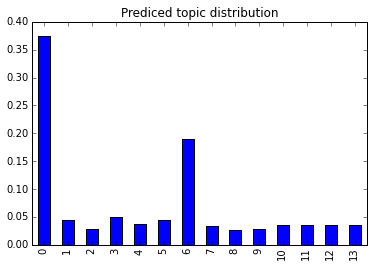

In [51]:
pd.Series(kos_state.predict(doc, r)[0]).plot(kind='bar').set_title('Prediced topic distribution')

The prediction is that this document is mostly generated by topic 7.

Similarly, if we create a document from words from the 1st and 7th topic, our prediction is that the document is generated mostly by those topics.

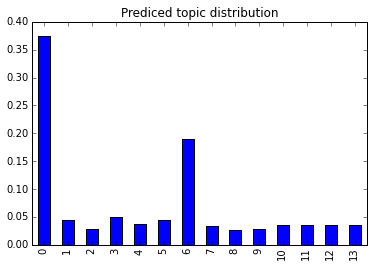

In [32]:
doc = [word for word, _ in relevance[0][:100]] + [word for word, _ in relevance[6][:100]]
shuffle(doc)
pd.Series(kos_state.predict(doc, r)[0]).plot(kind='bar').set_title('Prediced topic distribution')

### Topic and Term Distributions

Of course, we can also get the topic distribution for each document (commonly called $\Theta$).

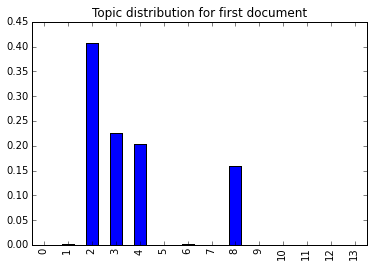

In [33]:
pd.Series(kos_state.topic_distribution_by_document()[0]).plot(kind='bar').set_title('Topic distribution for first document')

We can also get the raw word distribution for each topic (commonly called $\Phi$). This is related to the _word relevance_. Here are the most common words in one of the topics.

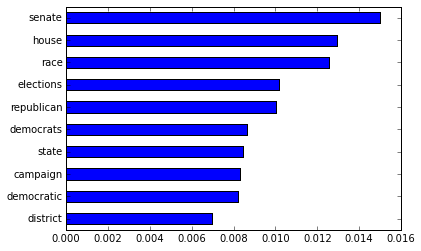

In [49]:
pd.Series(kos_state.word_distribution_by_topic()[3]).sort(inplace=False).tail(10).plot(kind='barh')